In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
100% 148M/149M [00:07<00:00, 23.7MB/s]
100% 149M/149M [00:07<00:00, 20.3MB/s]


# Exploratory Data Analysis

In [27]:
def get_class_paths(path):
  """
  Map file path to the classification of the tumor in that image.
  Args:
    . path: path to a folder with subfolders entitled the classification of the images inside it.
  Returns:
    . Pandas dataframe with columns: file path, classification.
  """
  classes = []
  class_paths = []

  # Iterate through directories in the training path
  for label in os.listdir(path):
      label_path = os.path.join(path, label)

      # Check if it's a directory
      if os.path.isdir(label_path):
          # Iterate through images in the label directory
          for image in os.listdir(label_path):
              image_path = os.path.join(label_path, image)

              # Add class and path to respective lists
              classes.append(label)
              class_paths.append(image_path)

  # Create a DataFrame with the collected data
  df = pd.DataFrame({
      'Class Path': class_paths,
      'Class': classes
  })

  return df

In [28]:
tr_df = get_class_paths("/content/Training")

In [29]:
tr_df

,Class Path,Class
0,/content/Training/pituitary/Tr-pi_0140.jpg,pituitary
1,/content/Training/pituitary/Tr-pi_0514.jpg,pituitary
2,/content/Training/pituitary/Tr-pi_0311.jpg,pituitary
3,/content/Training/pituitary/Tr-pi_1174.jpg,pituitary
4,/content/Training/pituitary/Tr-pi_0594.jpg,pituitary
...,...,...
5707,/content/Training/glioma/Tr-gl_0436.jpg,glioma
5708,/content/Training/glioma/Tr-gl_0859.jpg,glioma
5709,/content/Training/glioma/Tr-gl_0753.jpg,glioma
5710,/content/Training/glioma/Tr-gl_0733.jpg,glioma


Text(0.5, 1.0, 'Training Data Class Distribution')

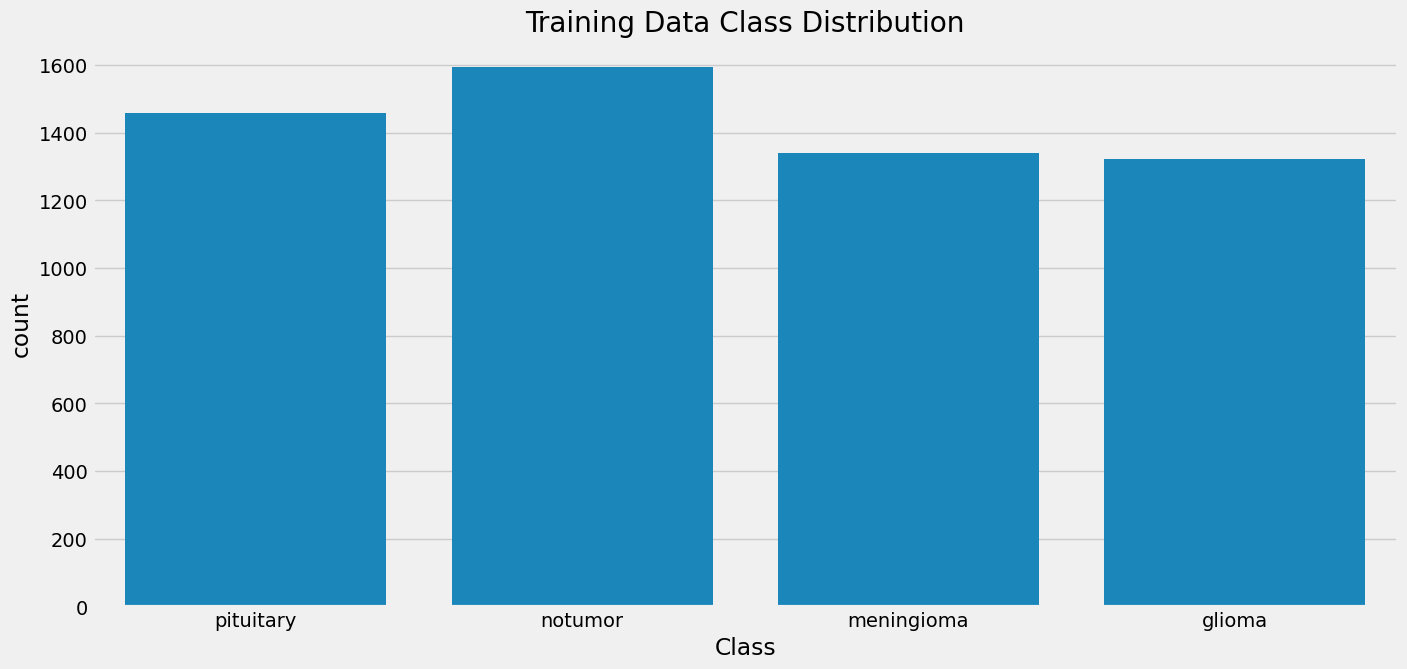

In [30]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df, x=tr_df['Class'])
plt.title("Training Data Class Distribution")

In [31]:
ts_df = get_class_paths("/content/Testing")

In [32]:
ts_df

,Class Path,Class
0,/content/Testing/pituitary/Te-pi_0064.jpg,pituitary
1,/content/Testing/pituitary/Te-pi_0132.jpg,pituitary
2,/content/Testing/pituitary/Te-pi_0059.jpg,pituitary
3,/content/Testing/pituitary/Te-pi_0099.jpg,pituitary
4,/content/Testing/pituitary/Te-pi_0040.jpg,pituitary
...,...,...
1306,/content/Testing/glioma/Te-gl_0169.jpg,glioma
1307,/content/Testing/glioma/Te-gl_0271.jpg,glioma
1308,/content/Testing/glioma/Te-gl_0206.jpg,glioma
1309,/content/Testing/glioma/Te-gl_0085.jpg,glioma


Text(0.5, 1.0, 'Testing Data Class Distribution')

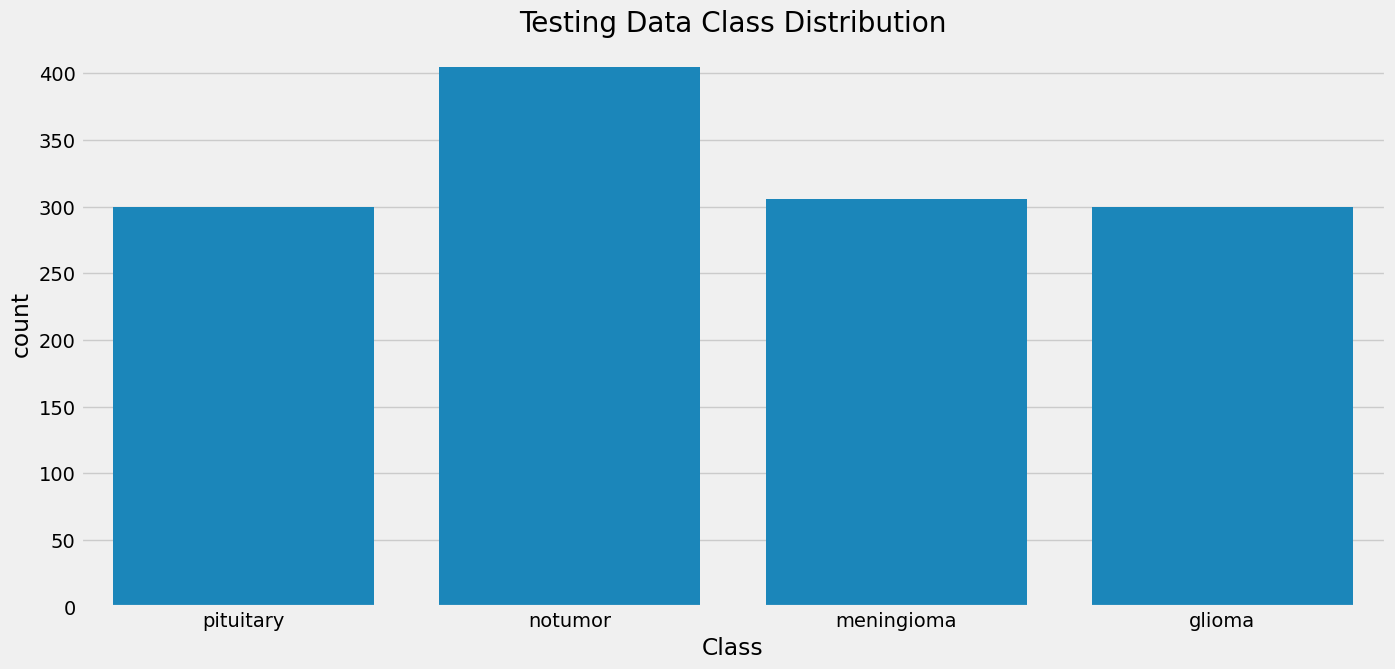

In [33]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=ts_df, x=ts_df['Class'])
plt.title("Testing Data Class Distribution")

# Data Preparation

Remove duplicates

In [ ]:
import hashlib

PROJECT_DIR = "/content"
LABELS = ['glioma', 'meningioma', 'no_tumor', 'pituitary']


def compute_hash(filepath):
    """
    Generate a unique hash value for a given file using the MD5 hashing algorithm.
    Args:
        . filepath: path to a file.
    Returns:
        . hash of the file.
    """
    hasher = hashlib.md5()          # create an instance of the MD5 hash object
    with open(filepath, 'rb') as f: # open the file in binary mode
        buf = f.read()              # read the file contents into a buffer
        hasher.update(buf)          # compute the hash and store it in hasher
    return hasher.hexdigest()       # return hexadecimal representation of hasher


def list_files(hash_dict):
    for data_type in ['Training', 'Testing']:
        for label in LABELS:
            folder_path = os.path.join(PROJECT_DIR, 'data', 'raw', data_type, label)
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    if file.endswith(".jpg"):
                        file_path = os.path.join(root, file)
                        file_hash = compute_hash(file_path)
                        if file_hash in hash_dict:
                            hash_dict[file_hash].append(file_path)
                        else:
                            hash_dict[file_hash] = [file_path]


def remove_duplicates(hash_dict):
    duplicate_count = 0
    for hash_value, file_paths in hash_dict.items():
        if len(file_paths) > 1:
            for file_path in file_paths[1:]:
                print(f"Removing duplicate (hash : {hash_value}) : {file_path}")
                os.remove(file_path)
                duplicate_count += 1
    print(f"Number of duplicates : {duplicate_count}")


if __name__ == '__main__':
    hash_dict = {}
    list_files(hash_dict)
    remove_duplicates(hash_dict)


Data Split

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [35]:
# set aside data for validation - use dta from the test dataset
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, stratify=ts_df['Class'])

In [36]:
valid_df

,Class Path,Class
66,/content/Testing/pituitary/Te-pi_0260.jpg,pituitary
950,/content/Testing/meningioma/Te-me_0117.jpg,meningioma
1214,/content/Testing/glioma/Te-gl_0137.jpg,glioma
970,/content/Testing/meningioma/Te-me_0216.jpg,meningioma
355,/content/Testing/notumor/Te-no_0351.jpg,notumor
...,...,...
798,/content/Testing/meningioma/Te-me_0249.jpg,meningioma
1156,/content/Testing/glioma/Te-gl_0040.jpg,glioma
973,/content/Testing/meningioma/Te-me_0174.jpg,meningioma
185,/content/Testing/pituitary/Te-pi_0029.jpg,pituitary


In [37]:
ts_df

,Class Path,Class
981,/content/Testing/meningioma/Te-me_0170.jpg,meningioma
180,/content/Testing/pituitary/Te-pi_0231.jpg,pituitary
680,/content/Testing/notumor/Te-no_0036.jpg,notumor
1091,/content/Testing/glioma/Te-glTr_0000.jpg,glioma
1226,/content/Testing/glioma/Te-gl_0011.jpg,glioma
...,...,...
221,/content/Testing/pituitary/Te-pi_0199.jpg,pituitary
20,/content/Testing/pituitary/Te-pi_0152.jpg,pituitary
726,/content/Testing/meningioma/Te-me_0258.jpg,meningioma
1269,/content/Testing/glioma/Te-gl_0224.jpg,glioma


## Data Preprocessing (Transformation)

In [38]:
# TODO: test with different values
# reduce bathc size
batch_size = 16
## ensure inputs are consistent
image_size = (224, 224)
## escale and transpose - standardize
image_generator = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))
ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen = image_generator.flow_from_dataframe(tr_df,
                                           x_col='Class Path',
                                           y_col='Class',
                                           batch_size=batch_size,
                                           target_size=image_size)

valid_gen = image_generator.flow_from_dataframe(valid_df,
                                              x_col='Class Path',
                                              y_col='Class',
                                              batch_size=batch_size,
                                              target_size=image_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df,
                                   x_col='Class Path',
                                   y_col='Class',
                                   batch_size=16,
                                   target_size=image_size,
                                   shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


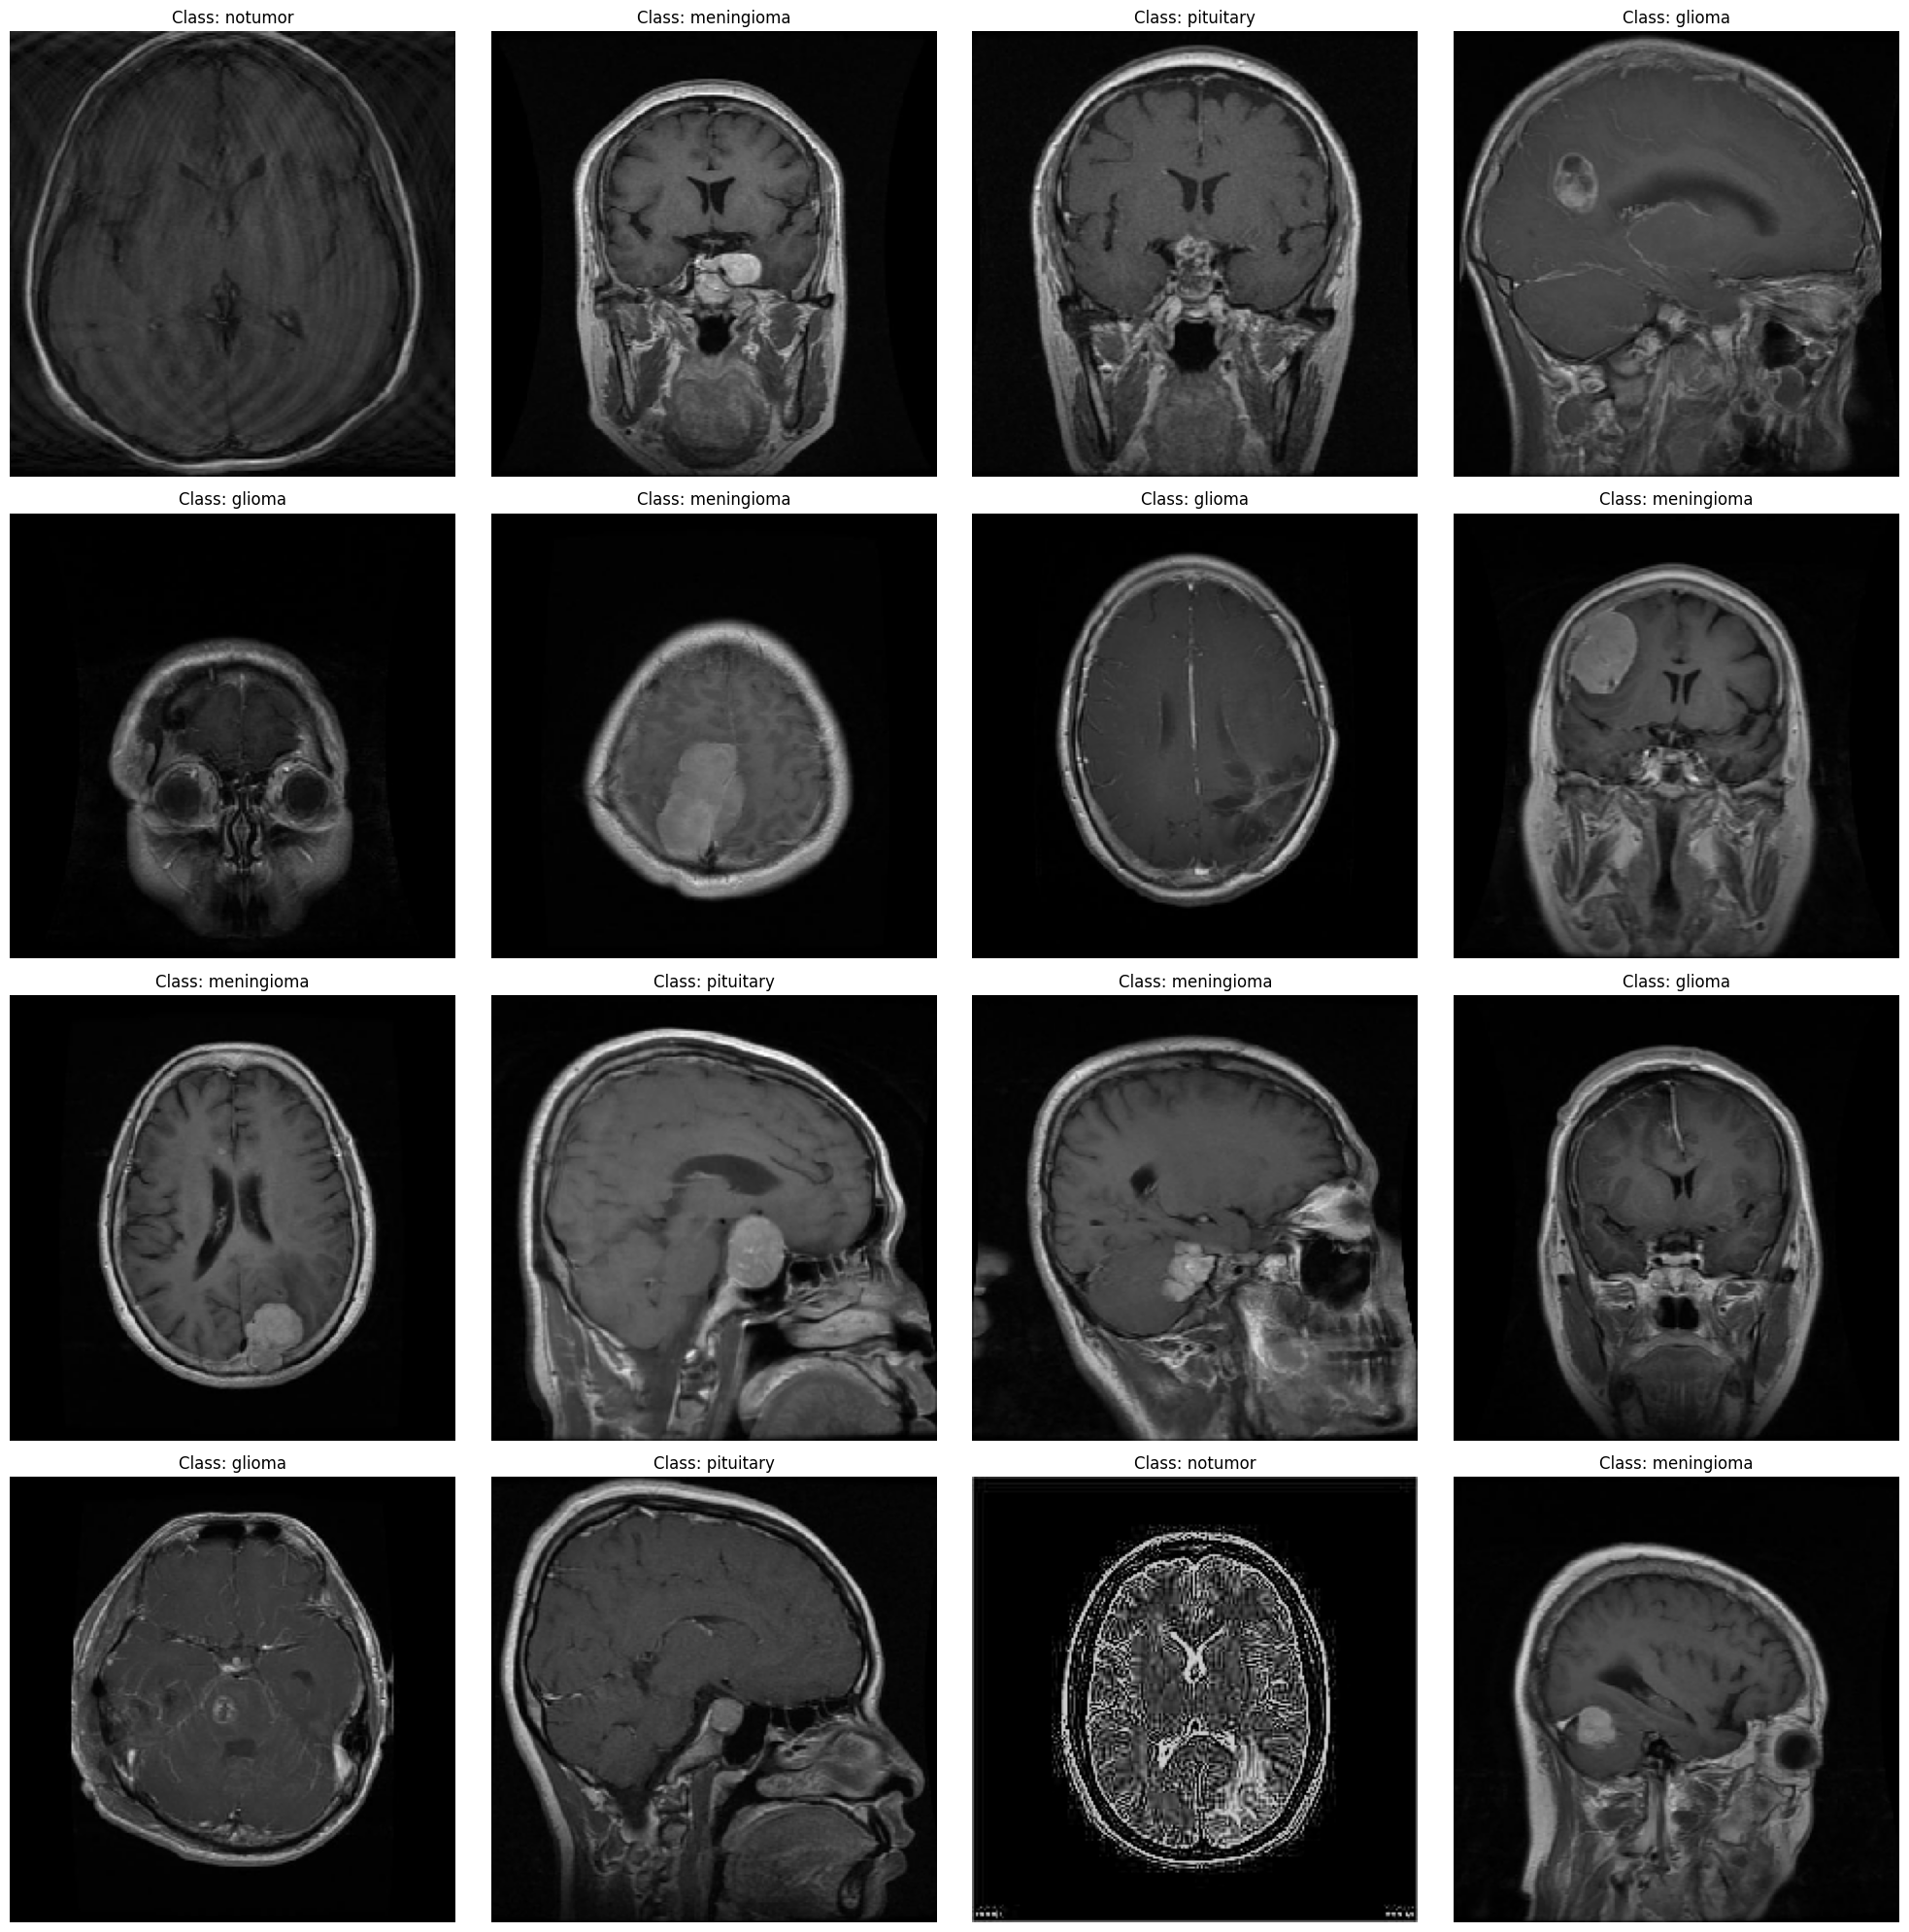

In [15]:
plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i+1)
    batch = next(tr_gen)
    image = batch[0][0]
    label = batch[1][0]
    plt.imshow(image)

    # Get the class index
    class_index = np.argmax(label)

    # Get the list of class names and class indices
    class_names = list(tr_gen.class_indices.keys())
    class_indices = list(tr_gen.class_indices.values())

    # Find the index of the class_index in the list of indices
    index_position = class_indices.index(class_index)

    # Get the class name using the index position
    class_name = class_names[index_position]

    plt.title(f"Class: {class_name}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# CNN

## Model Design

In [39]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# Check if cnn_model already exists and delete it
tf.keras.backend.clear_session()

In [40]:
# Create a Sequential model
cnn_model = Sequential()

# Convolutional layers
cnn_model.add(Conv2D(512, (3, 3), padding='same', input_shape=(224,224,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output for fully connected layers
cnn_model.add(Flatten())

# Fully connected layers
cnn_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(Dropout(0.35))

cnn_model.add(Dense(4, activation='softmax'))  # Output layer with 4 neurons for the 4 classes

# Compile the model
cnn_model.compile(
    Adamax(learning_rate = 0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Display the model summary
cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 512)       │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 512)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 256)       │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,775,620 (18.22 MB)

 Trainable params: 4,775,620 (18.22 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Create a Sequential model
cnn_model = Sequential([

    # Convolutional layer 1
    Conv2D(32, (4, 4), activation="relu", input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    # Full connect layers
    Dense(512, activation="relu"),
    Dropout(0.5, seed=111),
    Dense(4, activation="softmax")
])

# Compile the model
cnn_model.compile(
    Adamax(learning_rate = 0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Display the model summary
cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 221, 221, 32)        │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 73, 73, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 70, 70, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 3, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,020,260 (3.89 MB)

 Trainable params: 1,020,260 (3.89 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [18]:
hist = cnn_model.fit(tr_gen, epochs=25, validation_data=valid_gen)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


357/357 ━━━━━━━━━━━━━━━━━━━━ 32s 66ms/step - accuracy: 0.4932 - loss: 1.0572 - precision: 0.7429 - recall: 0.2881 - val_accuracy: 0.7038 - val_loss: 0.7108 - val_precision: 0.7358 - val_recall: 0.6718
Epoch 2/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.7995 - loss: 0.5172 - precision: 0.8253 - recall: 0.7618 - val_accuracy: 0.8061 - val_loss: 0.4868 - val_precision: 0.8244 - val_recall: 0.7740
Epoch 3/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.8373 - loss: 0.4125 - precision: 0.8571 - recall: 0.8123 - val_accuracy: 0.8290 - val_loss: 0.4069 - val_precision: 0.8491 - val_recall: 0.8076
Epoch 4/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.8917 - loss: 0.2906 - precision: 0.9001 - recall: 0.8816 - val_accuracy: 0.8687 - val_loss: 0.3127 - val_precision: 0.8827 - val_recall: 0.8504
Epoch 5/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.9100 - loss: 0.2363 - precision: 0.9156 - recall: 0.8949 - val_accuracy: 0.8916 - val_loss: 0.2

## Evaluation

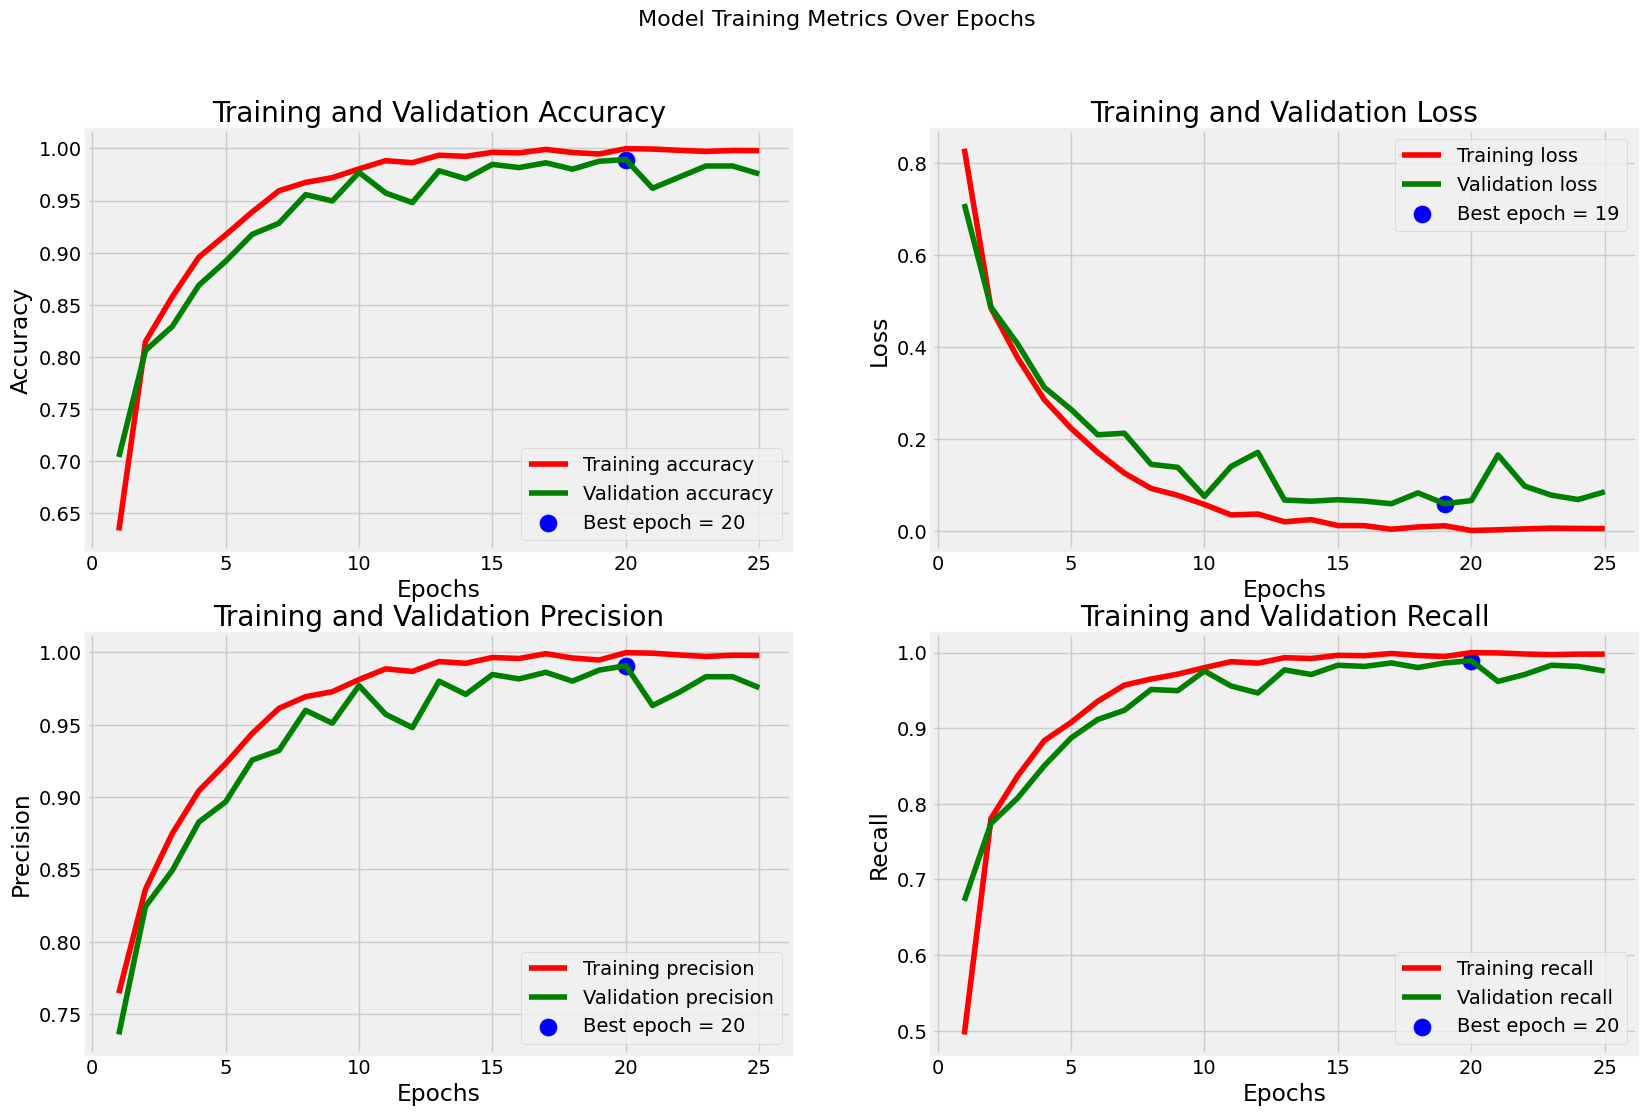

In [19]:
# Get training and validation metrics from history
metrics = ['accuracy', 'loss', 'precision', 'recall']
tr_metrics = {m: hist.history[m] for m in metrics}
val_metrics = {m: hist.history[f'val_{m}'] for m in metrics}

# Find best epochs and values
best_epochs = {}
best_values = {}
for m in metrics:
    if m == 'loss':
        idx = np.argmin(val_metrics[m])
    else:
        idx = np.argmax(val_metrics[m])
    best_epochs[m] = idx + 1
    best_values[m] = val_metrics[m][idx]

# Plot metrics
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    epochs = range(1, len(tr_metrics[metric]) + 1)

    plt.plot(epochs, tr_metrics[metric], 'r', label=f'Training {metric}')
    plt.plot(epochs, val_metrics[metric], 'g', label=f'Validation {metric}')
    plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue',
                label=f'Best epoch = {best_epochs[metric]}')

    plt.title(f'Training and Validation {metric.title()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [20]:
# assess overfit
train_score = cnn_model.evaluate(tr_gen, verbose=1) # how well does the model learn?
valid_score = cnn_model.evaluate(valid_gen, verbose=1) # how effective is the training process?

# assess performance
test_score = cnn_model.evaluate(ts_gen, verbose=1) # how does the model perform on unseen data?

print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train Loss: {train_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\nTest Accuracy: {test_score[1]*100:.2f}%")
print(f"Test Loss: {test_score[0]:.4f}")

357/357 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.9991 - loss: 0.0020 - precision: 0.9991 - recall: 0.9991
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9774 - loss: 0.0787 - precision: 0.9774 - recall: 0.9774
 7/41 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9692 - loss: 0.1121 - precision: 0.9692 - recall: 0.9692

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9701 - loss: 0.1001 - precision: 0.9701 - recall: 0.9701
Train Accuracy: 99.93%
Train Loss: 0.0020
Validation Accuracy: 97.56%
Validation Loss: 0.0957

Test Accuracy: 97.10%
Test Loss: 0.1117


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


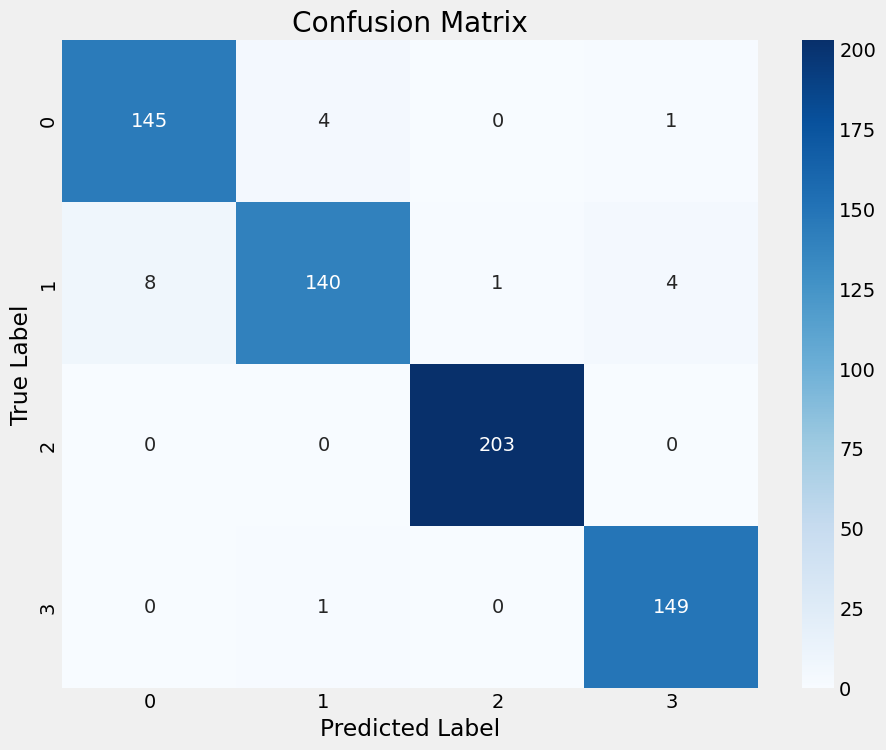

In [21]:
# Make predictions
preds = cnn_model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1) # retruns the class with the highest value (probability)

# Define class dictionary
class_dict = {
    0: 'glioma',
    1: 'meningioma',
    2: 'no_tumor',
    3: 'pituitary'
}

# Then create and display the confusion matrix
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [22]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       150
           1       0.97      0.92      0.94       153
           2       1.00      1.00      1.00       203
           3       0.97      0.99      0.98       150

    accuracy                           0.97       656
   macro avg       0.97      0.97      0.97       656
weighted avg       0.97      0.97      0.97       656



In [24]:
# Save the model
cnn_model.save("cnn_model_2.h5")